In [1]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!pip install pyarrow
!pip install pygam

In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import gc
import math
import re

from tqdm import tqdm
from collections import Counter

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import roc_auc_score

import lightgbm as lgb
from pygam import LogisticGAM

import warnings
warnings.simplefilter(action='ignore')

# change to path
PATH='/content/drive/My Drive/Colab Notebooks/grab/'
os.chdir(PATH)

In [0]:
PATH_LABELS = PATH + 'safety/labels'
PATH_FEATURES = PATH + 'safety/features'

## Read in
Start working from the aggregated dataframe `agg_df`.

In [5]:
train_df = pd.read_feather(f'{PATH_FEATURES}/sample_new_151')

train_df.drop('count', axis=1, inplace=True)

train_df.head()

,bookingID,Accuracy_max,Accuracy_mean,Accuracy_std,Bearing_max,Bearing_mean,Bearing_std,acceleration_x_max,acceleration_x_mean,acceleration_x_std,acceleration_y_max,acceleration_y_mean,acceleration_y_std,acceleration_z_max,acceleration_z_mean,acceleration_z_std,gyro_x_max,gyro_x_mean,gyro_x_std,gyro_y_max,gyro_y_mean,gyro_y_std,gyro_z_max,gyro_z_mean,gyro_z_std,second_max,second_mean,second_std,Speed_max,Speed_mean,Speed_std,total_a_max,total_a_mean,total_a_std,total_gyro_max,total_gyro_mean,total_gyro_std,roll_max,roll_mean,roll_std,...,acceleration_z_so_mean,acceleration_z_so_min,acceleration_z_so_max,acceleration_z_sign_change,gyro_x_fo_mean,gyro_x_fo_min,gyro_x_fo_max,gyro_x_so_mean,gyro_x_so_min,gyro_x_so_max,gyro_x_sign_change,gyro_y_fo_mean,gyro_y_fo_min,gyro_y_fo_max,gyro_y_so_mean,gyro_y_so_min,gyro_y_so_max,gyro_y_sign_change,gyro_z_fo_mean,gyro_z_fo_min,gyro_z_fo_max,gyro_z_so_mean,gyro_z_so_min,gyro_z_so_max,gyro_z_sign_change,roll_fo_mean,roll_fo_min,roll_fo_max,roll_so_mean,roll_so_min,roll_so_max,roll_sign_change,pitch_fo_mean,pitch_fo_min,pitch_fo_max,pitch_so_mean,pitch_so_min,pitch_so_max,pitch_sign_change,label
0,0,48.000,10.165339,3.855898,359.979767,176.526099,129.231351,4.782614,-0.711264,0.928022,-6.119916,-9.613822,0.639934,2.318857,-1.619658,1.141266,0.438371,0.003328,0.065954,0.469724,-0.006118,0.100225,0.372807,-0.004188,0.063685,1589.0,903.526892,533.745097,22.946083,8.994822,7.199919,12.988328,9.886164,0.624159,0.749086,0.100772,0.091389,-1.347602,-1.737242,0.116742,...,0.002131,-9.415692,10.856174,144.0,0.000062,-0.470277,0.446838,-0.000139,-0.878883,0.792117,503.0,0.000133,-0.609200,0.632817,-0.000037,-0.982114,1.163994,519.0,-0.000056,-0.731597,0.860446,-0.000050,-1.010095,1.592042,489.0,0.000171,-0.470042,0.615583,0.000202,-0.940743,1.047816,0.0,0.000157,-0.441226,0.505558,0.000210,-0.853901,0.918500,278.0,0
1,1,7.709,3.718763,0.597933,337.000000,124.198590,89.861236,3.813341,-0.525406,0.744157,12.536156,9.532086,0.533915,1.481293,-2.198999,0.854271,0.126536,-0.002467,0.027740,0.470837,-0.007540,0.091699,0.235131,0.000405,0.033838,1034.0,581.175088,289.339367,21.882141,7.881588,7.059362,12.790147,9.862507,0.519956,0.717864,0.066187,0.077463,2.137340,1.797626,0.088049,...,0.002540,-9.591842,7.498774,24.0,-0.000050,-0.179333,0.121126,-0.000053,-0.246702,0.291941,428.0,0.000008,-0.717767,0.596711,-0.000281,-0.782274,1.275626,433.0,-0.000069,-0.216438,0.275204,-0.000048,-0.484521,0.283110,415.0,-0.000096,-0.537245,0.523479,-0.000285,-0.783427,0.965273,0.0,0.000099,-0.488136,0.452367,-0.000123,-0.832619,0.931832,180.0,1
2,2,8.000,3.930626,1.117354,354.000000,173.794872,119.316520,1.956122,0.306786,0.756589,13.333716,9.843183,0.505693,2.312870,0.139347,1.020021,0.282162,0.006458,0.053903,0.431695,-0.012861,0.117321,0.255884,0.002597,0.036215,825.0,339.441026,356.319445,9.360483,3.157213,2.897762,13.403410,9.929590,0.515173,0.463685,0.097433,0.093028,1.891112,1.556422,0.102860,...,0.006488,-7.043957,8.842057,88.0,-0.000356,-0.277944,0.298713,-0.000529,-0.576657,0.397062,98.0,0.001603,-0.638354,0.507018,-0.000608,-1.034806,0.967000,101.0,-0.000482,-0.276111,0.258396,-0.000215,-0.534507,0.324369,113.0,-0.000391,-0.436176,0.478420,-0.000621,-0.777169,0.635099,0.0,-0.000304,-0.310418,0.329223,-0.001784,-0.639641,0.490599,80.0,1
3,4,10.000,10.000000,0.000000,353.855377,151.807013,71.273774,2.019635,-0.365117,0.527220,-7.064984,-9.406439,0.598023,0.296381,-2.613639,0.779529,0.438732,-0.022884,0.042342,0.652628,0.023232,0.112567,0.505220,-0.000376,0.065927,1094.0,547.495430,315.962793,19.780001,6.150996,5.595901,21.053265,9.813434,0.620066,0.661675,0.108875,0.089501,-1.537207,-1.841256,0.077592,...,0.001314,-10.440613,14.778207,4.0,0.000008,-0.500610,0.507631,-0.000057,-1.008241,0.800959,264.0,-0.000306,-0.577360,0.625146,0.000110,-1.186005,1.002399,519.0,-0.000012,-0.481751,0.561944,0.000108,-1.043695,0.714401,536.0,-0.000184,-0.366293,0.371167,0.000134,-0.728194,0.595339,0.0,0.000184,-0.325465,0.368603,-0.

In [0]:
# def encode_FE(df, col):
#     cv = df[col].value_counts()
#     nm = col+'_FE'
#     df[nm] = df[col].map(cv)
    
# freq_features = ['gyro_x_mean', 'gyro_z_so_mean', 'total_gyro_mean',
#                  'roll_max', 'Speed_min', 'total_gyro_min', 
#                  'horsepower_min', 'Bearing_min']    
    
# for c in freq_features:     
#   encode_FE(train_df, c)

In [38]:
select_f = features_df['features'].tolist()

len(select_f)

37

In [39]:
exclude = ['label', 'bookingID']

# features = [c for c in train_df.columns if c not in exclude]

features = select_f

len(features)

37

## Baseline
1. `lightgbm`

In [0]:
random_state = 42
np.random.seed(random_state)

folds = 5
skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=random_state)

In [0]:
val_aucs = []
feature_importance_df = pd.DataFrame()

oof = train_df[['bookingID', 'label']]
oof['predict'] = 0
oof = oof.reset_index()

In [0]:
lgb_params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'auc',
    'verbose': 1,
    'learning_rate': 0.05,
    'num_leaves': 31,
    'feature_fraction': 0.7,
    'min_data_in_leaf': 200,
    'bagging_fraction': 0.8,
    'bagging_freq': 20,
    'lambda_l1': 5,
    'lambda_l2': 5,
    'min_hessian': 0.01,
    'feature_fraction_seed': 2,
    'bagging_seed': 3,
    "seed": random_state
}

In [27]:
%%time
for fold, (trn_idx, val_idx) in enumerate(skf.split(train_df, train_df['label'])):
    X_train, y_train = train_df.iloc[trn_idx][features], train_df.iloc[trn_idx]['label']
    X_valid, y_valid = train_df.iloc[val_idx][features], train_df.iloc[val_idx]['label']
    
    trn_data = lgb.Dataset(X_train, label=y_train)
    val_data = lgb.Dataset(X_valid, label=y_valid)
    
    evals_result = {}
    
    lgb_clf = lgb.train(lgb_params,
                        trn_data,
                        500,
                        valid_sets=[trn_data, val_data],
                        early_stopping_rounds=100,
                        verbose_eval=100,
                        evals_result=evals_result)

    p_valid = lgb_clf.predict(X_valid[features], 
                              num_iteration=lgb_clf.best_iteration)

    oof['predict'][val_idx] = p_valid
    val_score = roc_auc_score(y_valid, p_valid)
    val_aucs.append(val_score)

Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.838691	valid_1's auc: 0.727631
[200]	training's auc: 0.896258	valid_1's auc: 0.726297
Early stopping, best iteration is:
[118]	training's auc: 0.851508	valid_1's auc: 0.728136
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.837138	valid_1's auc: 0.730959
[200]	training's auc: 0.897787	valid_1's auc: 0.728545
Early stopping, best iteration is:
[113]	training's auc: 0.84553	valid_1's auc: 0.732004
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.836277	valid_1's auc: 0.75279
[200]	training's auc: 0.896687	valid_1's auc: 0.751634
Early stopping, best iteration is:
[142]	training's auc: 0.864882	valid_1's auc: 0.754631
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.837675	valid_1's auc: 0.724901
[200]	training's auc: 0.897691	valid_1's auc: 0.725224
Early stopping, best iteration is:
[111]

In [28]:
mean_auc = np.mean(val_aucs)
std_auc = np.std(val_aucs)
all_auc = roc_auc_score(oof['label'], oof['predict'])
print("Mean auc: %.9f, std: %.9f. All auc: %.9f." % (mean_auc, std_auc, all_auc))

Mean auc: 0.732580195, std: 0.011465709. All auc: 0.732650056.


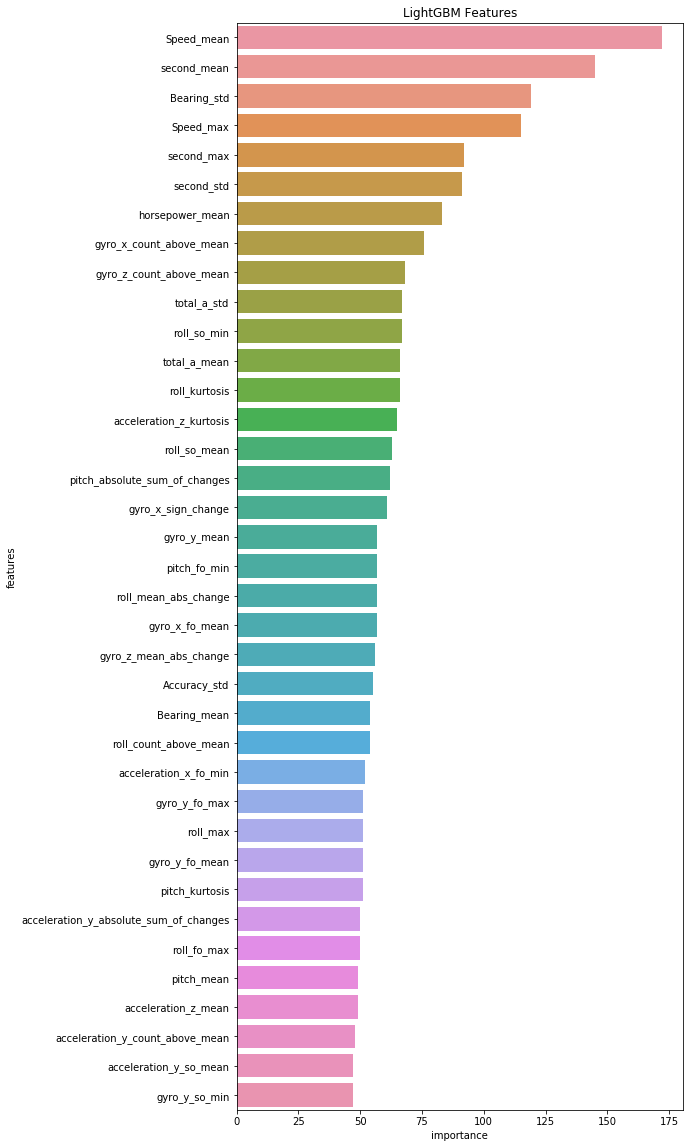

In [37]:
feature_score = lgb_clf.feature_importance()

features_df = pd.DataFrame({'features': features,
                            'importance': feature_score})

features_df = features_df.sort_values('importance', ascending=False)

features_df = features_df[:int(len(features)/2)]

plt.figure(figsize=(8,20))
sns.barplot(x="importance", y="features", 
            data=features_df)
plt.title('LightGBM Features')
plt.show()

In [0]:
s = StandardScaler()

X = s.fit_transform(train_df[features].values)
y = train_df['label'].values

In [0]:
np.random.seed(0)
lams = np.random.rand(5, 37) # random points on [0, 1], with shape (100, 3)
lams = lams * 8 - 3 # shift values to -3, 3
lams = np.exp(lams) 

In [76]:
%%time
gam = LogisticGAM().gridsearch(X, y, 
                               lam=lams,
                               keep_best=True)

100% (5 of 5) |##########################| Elapsed Time: 0:01:56 Time:  0:01:56


CPU times: user 3min 19s, sys: 15.1 s, total: 3min 34s
Wall time: 1min 56s


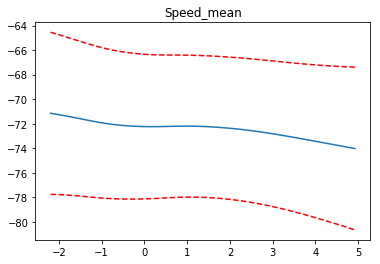

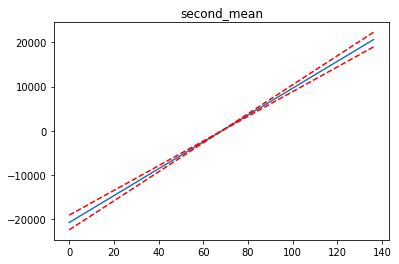

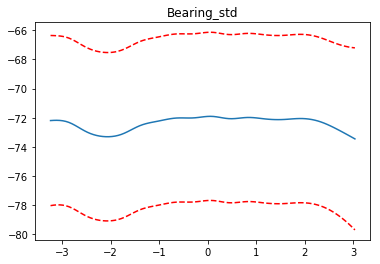

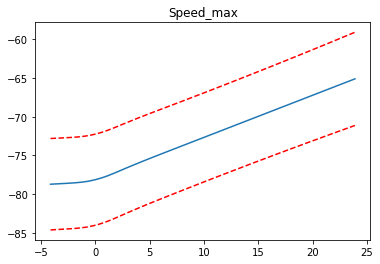

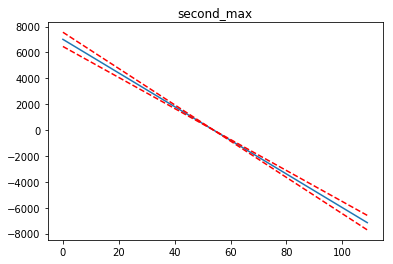

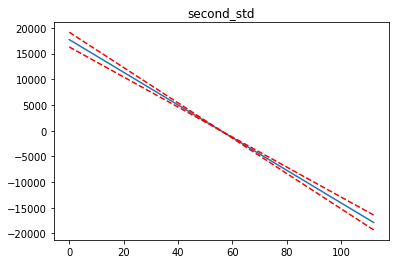

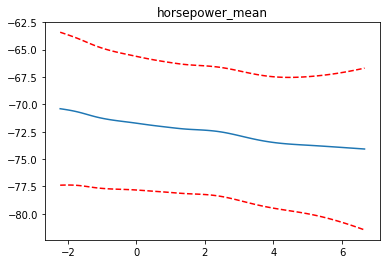

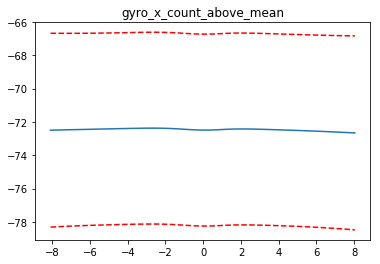

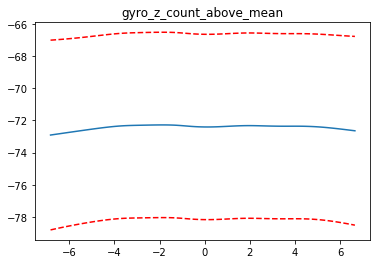

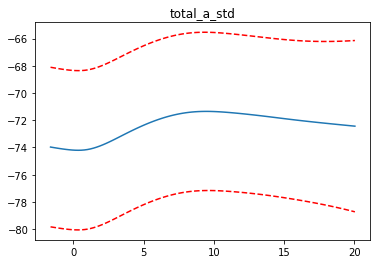

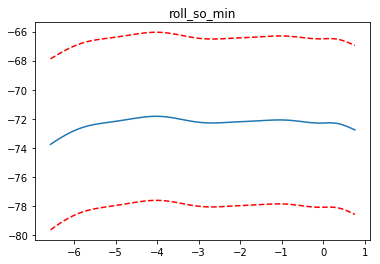

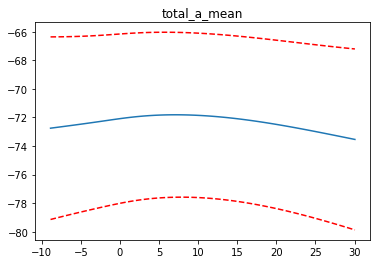

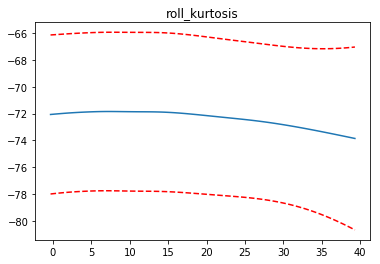

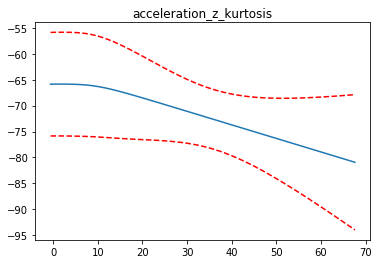

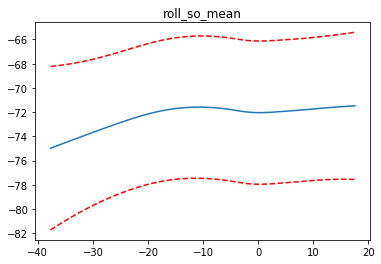

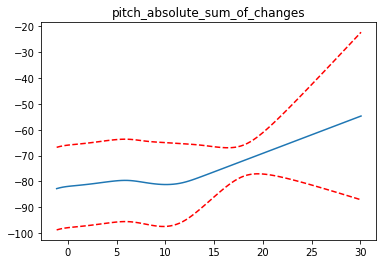

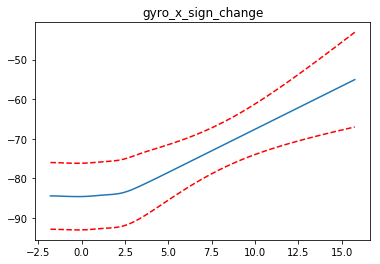

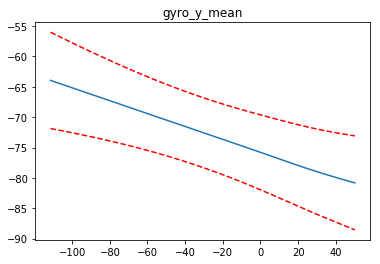

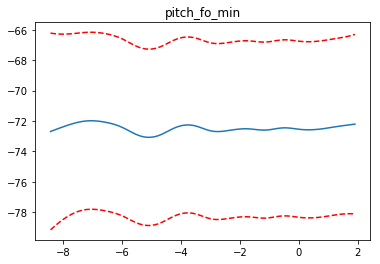

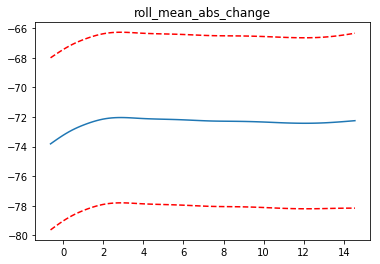

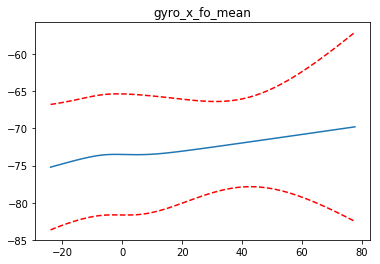

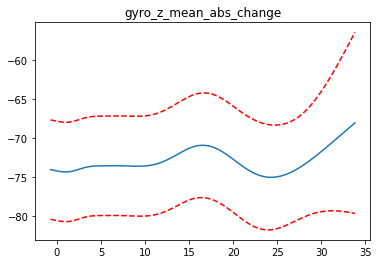

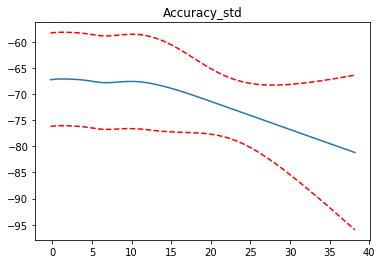

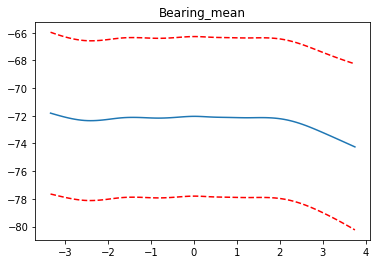

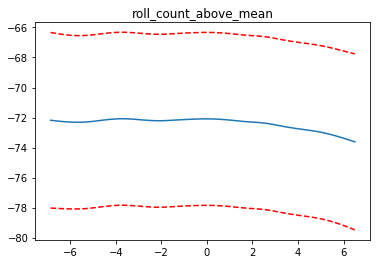

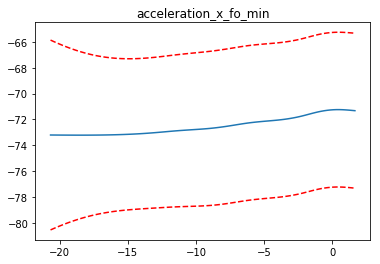

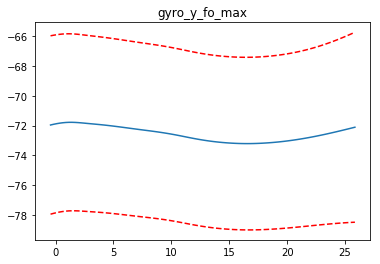

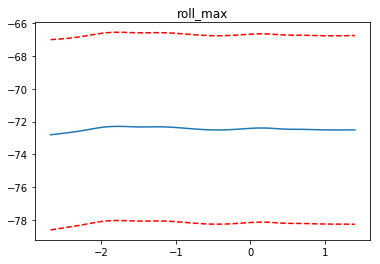

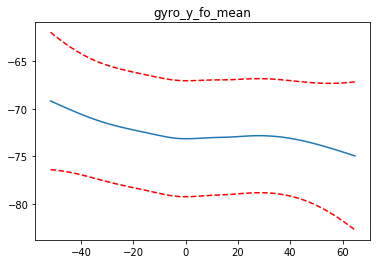

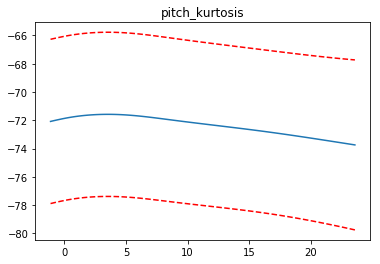

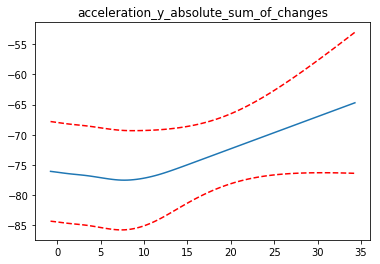

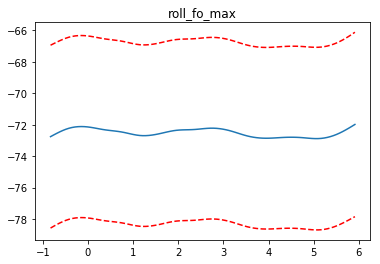

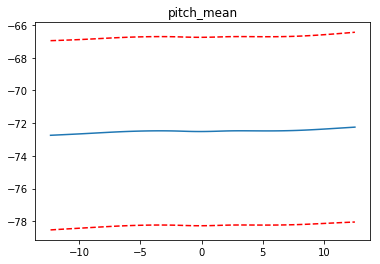

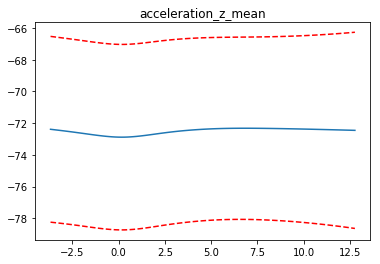

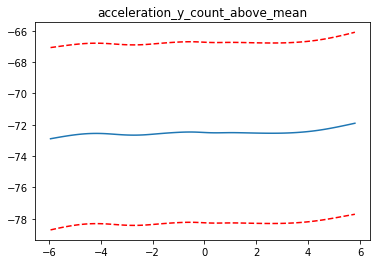

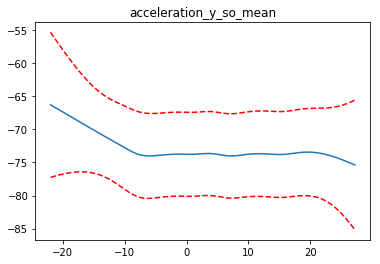

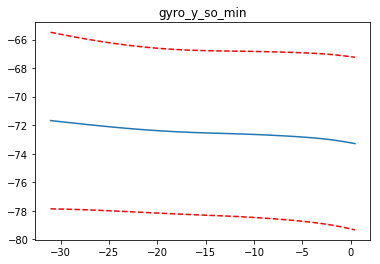

In [77]:
for i, term in enumerate(gam.terms):
    if term.isintercept:
        continue
        
    XX = gam.generate_X_grid(term=i)
    pdep, confi = gam.partial_dependence(term=i, X=XX, width=0.95)
    plt.figure()

    plt.plot(XX[:, term.feature], pdep)
    plt.plot(XX[:, term.feature], confi, c='r', ls='--')
    plt.title(features[i])
    plt.show()

In [78]:
gam.accuracy(X, y)

# gam.get_params()

0.77995

In [79]:
gam.summary()

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                    180.0983
Link Function:                        LogitLink Log Likelihood:                                 -9671.3045
Number of Samples:                        20000 AIC:                                            19702.8056
                                                AICc:                                           19706.1336
                                                UBRE:                                               2.9923
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.1402
Feature Function                  Lam

In [0]:
random_state = 42
np.random.seed(random_state)

folds = 4
skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=random_state)

val_aucs = []
feature_importance_df = pd.DataFrame()

oof = train_df[['bookingID', 'label']]
oof['predict'] = 0
oof = oof.reset_index()

In [81]:
%%time
for fold, (trn_idx, val_idx) in enumerate(skf.split(train_df, train_df['label'])):
  
    X_train = train_df.iloc[trn_idx][features].values
    y_train = train_df.iloc[trn_idx]['label'].values
    X_valid = train_df.iloc[val_idx][features].values
    y_valid = train_df.iloc[val_idx]['label'].values
    
    gam = LogisticGAM(lam=gam.lam).fit(X_train, y_train)        
    
    p_valid = gam.predict_proba(X_valid)
    
    # ===
    # impute NaN with 0
    # ===
    nans = np.where(np.isnan(p_valid))
    
    for i in nans:
        p_valid[i] = 0

    oof['predict'][val_idx] = p_valid
    val_score = roc_auc_score(y_valid, p_valid)
    
    print('fold {}\'s auc: {}'.format(fold+1, val_score))
    
    val_aucs.append(val_score)

fold 1's auc: 0.7057481481481482
fold 2's auc: 0.7502724266666667
fold 3's auc: 0.7069416533333334
fold 4's auc: 0.7018153107495333
CPU times: user 3min 56s, sys: 27.6 s, total: 4min 23s
Wall time: 2min 22s


In [82]:
mean_auc = np.mean(val_aucs)
std_auc = np.std(val_aucs)
all_auc = roc_auc_score(oof['label'], oof['predict'])
print("Mean auc: %.9f, std: %.9f. All auc: %.9f." % (mean_auc, std_auc, all_auc))

Mean auc: 0.716194385, std: 0.019766181. All auc: 0.716355575.
